## Задача 1. Линейная регрессия, метод градиентного спуска

Рыбина Екатерина Дмитриевна, 471 гр.

In [279]:
import pandas as pd
import numpy as np
from numpy import ndarray
import seaborn as sns

import random
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 4)
random.seed(19)
np.set_printoptions(precision=4)
np.random.seed(19)

[x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

In [280]:
def gradient_descent(X, y, alpha=1, epsilon=1):
    m, n = X.shape
    
    free_col = np.ones((X.shape[0], 1))
    x_long = np.concatenate((free_col,X), axis=1)
    
    n_new = n + 1
    
    W = np.ones(n_new,)
    
    old_cost = 0
    Q = 0
    lambd = 0.001
    
    while True:
        y_predicted = x_long.dot(W)

        loss = y_predicted - y
        RL2 = np.sum(np.square(W[1:]))
        Q = np.sum(loss ** 2) / n + 2.0 * alpha * RL2

        gradient = (2.0 / n) * (x_long.T.dot(loss) + alpha * W)

        W = W - lambd * gradient    

        if abs(Q - old_cost) < epsilon:
            break
            
        old_cost = Q
        
    return W

[x] * Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.

In [281]:
def stochastic_gd(X, y, alpha=1, lambd = 0.001, epsilon=1E-2, epochs=1000):
    m,n = X.shape

    free_col = np.ones((X.shape[0], 1))
    x_long = np.concatenate((free_col, X), axis=1)
    W = np.random.randn(n + 1).reshape(n + 1, 1)

    for _ in range(epochs):
        for i in range(m):

            idx = np.random.randint(0, m)

            X_i = x_long[idx, :].reshape(1, n + 1)
            y_i = y[idx].reshape(1, 1)

            y_predicted = X_i.dot(W)
            loss = y_predicted - y_i

            gradient = 2.0 * X_i.T.dot(loss) + alpha * W
            lg = lambd * gradient
            W = W - lg
            
            if np.all(abs(lg)<=epsilon):
                return W

    return W

[x] * Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

In [282]:
def mini_batch_gd(X, y, batches, lambd=0.01, epsilon=1E-2, epochs=1000):
    m,n = X.shape
    W = np.ones(X.shape[1])
    X = X.to_numpy()

    cost = 0
    k = 1
    for _ in range(epochs):
        for _ in range(int(m / batches)):
            idx = random.sample(range(m), batches)
            X_i = X[idx]
            y_i = y[idx]

            y_predicted = np.dot(X_i, W) + cost
            loss = y_i - y_predicted

            cost = cost - (lambd * -2 * np.mean(loss))

            gradient = -2 * np.dot(loss, X_i)
            lg = lambd * gradient
            W = W - lg

            if np.all(abs(lg) < epsilon):
                return W, cost
    return W, cost


[x] Найти данные, на которых интересно будет решать задачу регрессии.
Для решения задачи был взят набор данных для предсказания стоимости машин.
[x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).

In [283]:
df = pd.read_csv("car_price.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

ID автомобиля можно убрать, так как это никак не влияет на предсказание его стоимости:

In [284]:
df = df.drop(columns=["car_ID"])

In [285]:
df.isnull().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

В данном наборе нет пропущенных значений.

In [286]:
len(df['CarName'].unique())

147

Уникальных имён/марок автомобилей больше половины от общего числа. Следовательно имя так же не влияет на предсказание стоимости автомобиля. Данный признак можно убрать:

In [287]:
df = df.drop(columns=["CarName"])

Признаки carlength, carwidth, carheight и curbweight обобщаются признаком carbody.

In [288]:
df = df.drop(columns=["carlength", "carwidth", "carheight", "curbweight"])

[x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

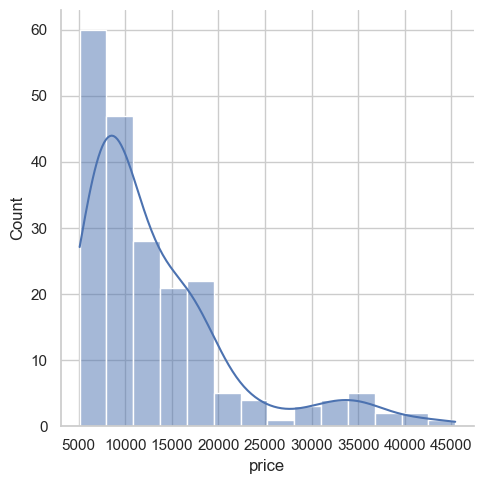

In [289]:
sns.displot(x='price', data=df, kde=True)

In [290]:
print("price       | count")
print(f" < 11k      | {df[df['price'] <= 11000].shape[0]}")
print(f" 11k-19k    | {df[(df['price'] > 11000) & (df['price'] <= 19000)].shape[0]}")
print(f" > 19k      | {df[df['price'] > 19000].shape[0]}")

price       | count
 < 11k      | 109
 11k-19k    | 68
 > 19k      | 28


Большинство автомобилей в ценовой категории от 5000 до примерно 11000. Затем идут 11000-19000, и самые дорогие начиная от 19000.

Теперь рассмотрим как влияет на цену вид топлива, который используется машиной

<AxesSubplot: xlabel='fueltype', ylabel='price'>

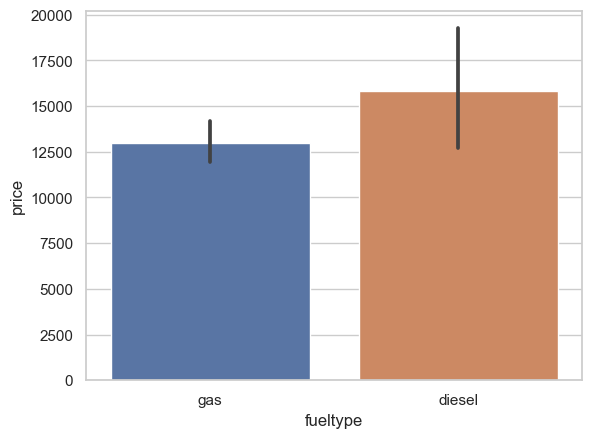

In [291]:
sns.barplot(x='fueltype', y='price', data=df)

<AxesSubplot: xlabel='carbody', ylabel='price'>

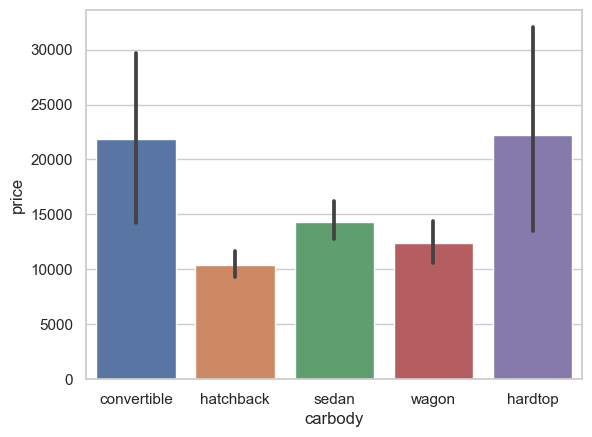

In [292]:
sns.barplot(x='carbody', y='price', data=df)

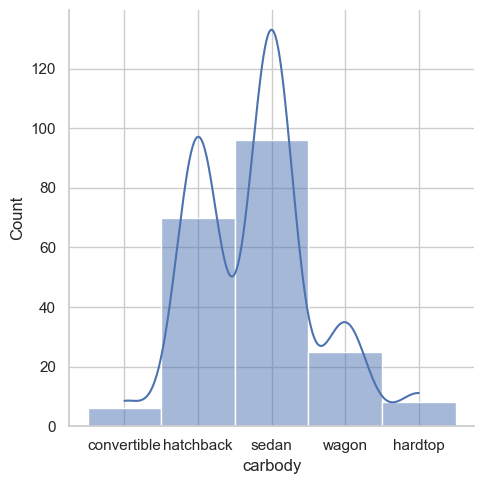

In [293]:
sns.displot(x='carbody', data=df, kde=True)

Sedan, hatchback и wagon являются наиболее предпачительными по цене чем convertible и hardtop

В среднем машины на газу дешевле, чем дизельные

[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**)

In [294]:
df['fueltype'].replace(['gas', 'diesel'], [1, 2], inplace=True)
df['aspiration'].replace(['std', 'turbo'], [1, 2], inplace=True)
df['doornumber'].replace(['two', 'four'], [2, 4], inplace=True)
df['carbody'].replace(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'], [1,2,3,4,5], inplace=True)
df['drivewheel'].replace(['rwd', 'fwd', '4wd'], [1,2,3], inplace=True)
df['enginelocation'].replace(['front', 'rear'], [1,2], inplace=True)
df['enginetype'].replace(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'], [1,2,3,4,5,6,7], inplace=True)
df['cylindernumber'].replace(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'], [4,6,5,3,12,2,8], inplace=True)
df['fuelsystem'].replace(['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', '4bbl', 'idi', 'spdi'], [1,2,3,4,5,6,7,8], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    int64  
 2   aspiration        205 non-null    int64  
 3   doornumber        205 non-null    int64  
 4   carbody           205 non-null    int64  
 5   drivewheel        205 non-null    int64  
 6   enginelocation    205 non-null    int64  
 7   wheelbase         205 non-null    float64
 8   enginetype        205 non-null    int64  
 9   cylindernumber    205 non-null    int64  
 10  enginesize        205 non-null    int64  
 11  fuelsystem        205 non-null    int64  
 12  boreratio         205 non-null    float64
 13  stroke            205 non-null    float64
 14  compressionratio  205 non-null    float64
 15  horsepower        205 non-null    int64  
 16  peakrpm           205 non-null    int64  
 1

[x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.

In [295]:
from sklearn.model_selection import train_test_split

X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

[x] При обучении моделей использовать **масштабирование данных**.

In [296]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

[x] * Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)**.

In [297]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal numbers of feature: {rfecv.n_features_}")
features = list(X_train_scaled.columns[rfecv.support_])
print(f"Selected features: {features}")

Optimal numbers of feature: 17
Selected features: ['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'citympg']


[x] * Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.

In [298]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha_grid = np.logspace(-3, 3, 10)
epsilon_grid = np.logspace(-3, 3, 10)

searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "tol": epsilon_grid}], scoring="neg_root_mean_squared_error", cv=2)
searcher.fit(X_train_scaled, y_train)

optimal_alpha = searcher.best_params_["alpha"]
print(f"Alpha: {optimal_alpha}")

optimal_epsilon = searcher.best_params_["tol"]
print(f"Epsilon: {optimal_epsilon}")

Alpha: 10.0
Epsilon: 0.001


[x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.

In [299]:
def get_model(X, w):
    n = X.shape[0]
    add_column = np.ones(n)
    X_update = np.c_[add_column, X]
    result = np.matmul(X_update, w)
    return result

In [300]:
w = gradient_descent(X_train_scaled, y_train, alpha=optimal_alpha, epsilon=optimal_epsilon)

y_train_gd_model = get_model(X_train_scaled, w)
y_test_gd_model = get_model(X_test_scaled, w)

In [301]:
from sklearn.metrics import mean_squared_error, r2_score
#MSE
my_lr_train_mse = mean_squared_error(y_train, y_train_gd_model, squared=True)
my_lr_test_mse = mean_squared_error(y_test, y_test_gd_model, squared=True)
print("MSE")
print(f"train: {my_lr_train_mse}")
print(f"test: {my_lr_test_mse}")

#RMSE
my_lr_train_rmse = mean_squared_error(y_train, y_train_gd_model, squared=False)
my_lr_test_rmse = mean_squared_error(y_test, y_test_gd_model, squared=False)
print("RMSE")
print(f"train: {my_lr_train_rmse}")
print(f"test: {my_lr_test_rmse}")

#R^2
my_lr_train_r2 = r2_score(y_train, y_train_gd_model)
my_lr_test_r2 = r2_score(y_test, y_test_gd_model)
print("MSE")
print(f"train: {my_lr_train_r2}")
print(f"test: {my_lr_test_r2}")

MSE
train: 8368139.000772457
test: 14228775.214008901
RMSE
train: 2892.773582700944
test: 3772.1048784476952
MSE
train: 0.8627039940629747
test: 0.7946322749917412


[x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.

In [302]:
ridge_model = Ridge(alpha=optimal_alpha, tol=optimal_epsilon)
ridge_model.fit(X_train_scaled, y_train)

y_train_ridge_model = ridge_model.predict(X_train_scaled)
y_test_ridge_model = ridge_model.predict(X_test_scaled)

In [303]:
#MSE
ridge_model_train_mse = mean_squared_error(y_train, y_train_ridge_model, squared=True)
ridge_model_test_mse = mean_squared_error(y_test, y_test_ridge_model, squared=True)
print("MSE")
print(f"train: {ridge_model_train_mse}")
print(f"test: {ridge_model_test_mse}")

#RMSE
ridge_model_train_rmse = mean_squared_error(y_train, y_train_ridge_model, squared=False)
ridge_model_test_rmse = mean_squared_error(y_test, y_test_ridge_model, squared=False)
print("RMSE")
print(f"train: {ridge_model_train_rmse}")
print(f"test: {ridge_model_test_rmse}")

#R^2
ridge_model_train_r2 = r2_score(y_train, y_train_ridge_model)
ridge_model_test_r2 = r2_score(y_test, y_test_ridge_model)
print("R^2")
print(f"train: {ridge_model_train_r2}")
print(f"test: {ridge_model_test_r2}")

MSE
train: 7600109.752857468
test: 12701334.70474446
RMSE
train: 2756.8296561190477
test: 3563.8931949126168
R^2
train: 0.8753050452849742
test: 0.8166782331121741


Реализация градиентного спуска по точности близка к библиотечной реализации

Обучение модели стохастического градиентного спуска

In [304]:
w_sgd = stochastic_gd(X_train_scaled, y_train.to_numpy(), alpha=optimal_alpha, epsilon=optimal_epsilon)
y_train_sgd_model = get_model(X_train_scaled, w_sgd)
y_test_sgd_model = get_model(X_test_scaled, w_sgd)

In [305]:
#MSE
sgd_model_train_mse = mean_squared_error(y_train, y_train_sgd_model, squared=True)
sgd_model_test_mse = mean_squared_error(y_test, y_test_sgd_model, squared=True)
print("MSE")
print(f"train: {sgd_model_train_mse}")
print(f"test: {sgd_model_test_mse}")

#RMSE
sgd_model_train_rmse = mean_squared_error(y_train, y_train_sgd_model, squared=False)
sgd_model_test_rmse = mean_squared_error(y_test, y_test_sgd_model, squared=False)
print("RMSE")
print(f"train: {sgd_model_train_rmse}")
print(f"test: {sgd_model_test_rmse}")

#R^2
sgd_model_train_r2 = r2_score(y_train, y_train_sgd_model)
sgd_model_test_r2 = r2_score(y_test, y_test_sgd_model)
print("R^2")
print(f"train: {sgd_model_train_r2}")
print(f"test: {sgd_model_test_r2}")

MSE
train: 136141730.81402385
test: 144544011.6370506
RMSE
train: 11667.978865854353
test: 12022.645783564058
R^2
train: -1.2336765534599397
test: -1.0862424479263968


Обучение своей модели мини-пакетного градиентного спуска

In [306]:
batches = int(X_train_scaled.shape[0]/50)
w_mbgd, cost = mini_batch_gd(X_train_scaled, y_train.to_numpy(),
                            epsilon=optimal_epsilon,
                            batches=batches)

y_train_mbgd_model = np.dot(X_train_scaled, w_mbgd) + cost
y_test_mbgd_model = np.dot(X_test_scaled, w_mbgd) + cost

In [307]:
#MSE
mbgd_model_train_mse = mean_squared_error(y_train, y_train_mbgd_model, squared=True)
mbgd_model_test_mse = mean_squared_error(y_test, y_test_mbgd_model, squared=True)
print("MSE")
print(f"train: {mbgd_model_train_mse}")
print(f"test: {mbgd_model_test_mse}")

#RMSE
mbgd_model_train_rmse = mean_squared_error(y_train, y_train_mbgd_model, squared=False)
mbgd_model_test_rmse = mean_squared_error(y_test, y_test_mbgd_model, squared=False)
print("RMSE")
print(f"train: {mbgd_model_train_rmse}")
print(f"test: {mbgd_model_test_rmse}")

#R^2
mbgd_model_train_r2 = r2_score(y_train, y_train_mbgd_model)
mbgd_model_test_r2 = r2_score(y_test, y_test_mbgd_model)
print("R^2")
print(f"train: {mbgd_model_train_r2}")
print(f"test: {mbgd_model_test_r2}")

MSE
train: 9899361.79717826
test: 14891420.653708983
RMSE
train: 3146.325125790127
test: 3858.9403537381845
R^2
train: 0.8375812309101598
test: 0.7850681358166195


[x] Повторить тоже самое, но используя **кросс-валидацию**.

[x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.

In [308]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
splited_samples = kfold.split(X=X_train_scaled, y=y_train)

gradient_descent

In [309]:
results_df = pd.DataFrame(index=['mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

for fold, (train, test) in enumerate(splited_samples):
    searcher.fit(X_train_scaled_df.iloc[train,:], y_train.iloc[train] )
    optimal_alpha_fold = searcher.best_params_["alpha"]
    optimal_epsilon_fold = searcher.best_params_["tol"]
    w_fold = gradient_descent(X_train_scaled_df.iloc[train,:], 
                              y_train.iloc[train], 
                              alpha=optimal_alpha_fold, epsilon=optimal_epsilon_fold)

    y_train_model_fold = get_model(X_train_scaled_df.iloc[train,:], w_fold)
    y_test_model_fold = get_model(X_train_scaled_df.iloc[test,:],w_fold)

    mse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=True)
    mse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=True)

    rmse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=False)
    rmse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=False)

    r2_train = r2_score(y_train.iloc[train], y_train_model_fold)
    r2_test = r2_score(y_train.iloc[test], y_test_model_fold)

    results_df.insert(fold, f"Fold {fold+1}",
                      [mse_train, mse_test,
                       rmse_train, rmse_test,
                       r2_train, r2_test])

mean = results_df.mean(axis=1)
std = results_df.std(axis=1)
results_df['mean'] = mean
results_df['std'] = std

In [310]:
results_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,mean,std
mse-train,9.6529e+06,9.8314e+06,6.9174e+06,7.6332e+06,7.2435e+06,8.2557e+06,1.3819e+06
mse-test,5.8555e+06,5.6514e+06,1.0458e+07,1.7754e+07,1.9033e+07,1.1750e+07,6.3777e+06
rmse-train,3.1069e+03,3.1355e+03,2.6301e+03,2.7628e+03,2.6914e+03,2.8653e+03,2.3847e+02
rmse-test,2.4198e+03,2.3773e+03,3.2339e+03,4.2136e+03,4.3626e+03,3.3214e+03,9.4765e+02
r2-train,8.5292e-01,8.5391e-01,8.8605e-01,8.6605e-01,8.6532e-01,8.6485e-01,1.3351e-02
r2-test,8.5826e-01,8.3292e-01,8.3033e-01,7.5882e-01,7.8538e-01,8.1314e-01,4.0138e-02


Ridge

In [311]:
from sklearn.model_selection import cross_val_score

ridge_df = pd.DataFrame(index=['mse', 'rmse', 'r2'])
model = Ridge(alpha=optimal_alpha, tol=optimal_epsilon)

mse = cross_val_score(model, X_train_scaled_df, y_train, cv=kfold, scoring="neg_mean_squared_error")
rmse = cross_val_score(model, X_train_scaled_df, y_train, cv=kfold, scoring="neg_root_mean_squared_error")
r2 = cross_val_score(model, X_train_scaled_df, y_train, cv=kfold, scoring="r2")

for fold in range(5):
    ridge_df.insert(fold, f"Fold {fold+1}", [-mse[fold],-rmse[fold],r2[fold]])

mean = ridge_df.mean(axis=1)
std = ridge_df.std(axis=1)
ridge_df['mean'] = mean
ridge_df['std']= std

In [312]:
ridge_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,mean,std
mse,4.5523e+06,4.2428e+06,9.9443e+06,1.5682e+07,1.6423e+07,1.0169e+07,5.8357e+06
rmse,2.1336e+03,2.0598e+03,3.1535e+03,3.9600e+03,4.0525e+03,3.0719e+03,9.5679e+02
r2,8.8981e-01,8.7457e-01,8.3866e-01,7.8697e-01,8.1481e-01,8.4096e-01,4.2188e-02


stochastic_gd

In [313]:
kfold = KFold(n_splits=5)
splited_samples = kfold.split(X=X_train_scaled, y=y_train)

sgd_df = pd.DataFrame(index=['mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

for fold, (train, test) in enumerate(splited_samples):
    searcher.fit(X_train_scaled_df.iloc[train,:], y_train.iloc[train] )
    optimal_alpha_fold = searcher.best_params_["alpha"]
    optimal_epsilon_fold = searcher.best_params_["tol"]
    w_fold = stochastic_gd(X_train_scaled_df.iloc[train,:], 
                              y_train.iloc[train].to_numpy(), 
                              alpha=optimal_alpha_fold, epsilon=optimal_epsilon_fold)

    y_train_model_fold = get_model(X_train_scaled_df.iloc[train,:], w_fold)
    y_test_model_fold = get_model(X_train_scaled_df.iloc[test,:],w_fold)

    mse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=True)
    mse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=True)

    rmse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=False)
    rmse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=False)

    r2_train = r2_score(y_train.iloc[train], y_train_model_fold)
    r2_test = r2_score(y_train.iloc[test], y_test_model_fold)

    sgd_df.insert(fold, f"Fold {fold+1}",
                      [mse_train, mse_test,
                       rmse_train, rmse_test,
                       r2_train, r2_test])

mean = sgd_df.mean(axis=1)
std = sgd_df.std(axis=1)
sgd_df['mean'] = mean
sgd_df['std'] = std

In [314]:
sgd_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,mean,std
mse-train,1.5696e+08,1.4854e+08,5.9673e+07,1.4743e+08,1.4347e+08,1.3121e+08,4.0293e+07
mse-test,1.4438e+08,1.5017e+08,6.2251e+07,2.0186e+08,1.9014e+08,1.4976e+08,5.4845e+07
rmse-train,1.2528e+04,1.2188e+04,7.7248e+03,1.2142e+04,1.1978e+04,1.1312e+04,2.0153e+03
rmse-test,1.2016e+04,1.2254e+04,7.8899e+03,1.4208e+04,1.3789e+04,1.2031e+04,2.5014e+03
r2-train,-1.3916e+00,-1.2071e+00,1.6997e-02,-1.5872e+00,-1.6677e+00,-1.1673e+00,6.8577e-01
r2-test,-2.4948e+00,-3.4395e+00,-9.9927e-03,-1.7421e+00,-1.1441e+00,-1.7661e+00,1.3041e+00


mini_batch_gd

In [315]:
kfold = KFold(n_splits=5)
splited_samples = kfold.split(X=X_train_scaled, y=y_train)

mbgd_df = pd.DataFrame(index=['mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

for fold, (train, test) in enumerate(splited_samples):
    searcher.fit(X_train_scaled_df.iloc[train,:], y_train.iloc[train] )
    optimal_epsilon_fold = searcher.best_params_["tol"]
    
    batches_fold = int(X_train_scaled_df.iloc[train,:].shape[0]/50)
    w_fold, cost_fold = mini_batch_gd(X_train_scaled_df.iloc[train,:], 
                              y_train.iloc[train].to_numpy(), 
                              epsilon=optimal_epsilon_fold,
                              batches=batches_fold)

    y_train_model_fold = np.dot(X_train_scaled_df.iloc[train,:], w_fold) + cost_fold
    y_test_model_fold = np.dot(X_train_scaled_df.iloc[test,:],w_fold) + cost_fold

    mse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=True)
    mse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=True)

    rmse_train = mean_squared_error(y_train.iloc[train], y_train_model_fold, squared=False)
    rmse_test = mean_squared_error(y_train.iloc[test], y_test_model_fold, squared=False)

    r2_train = r2_score(y_train.iloc[train], y_train_model_fold)
    r2_test = r2_score(y_train.iloc[test], y_test_model_fold)

    mbgd_df.insert(fold, f"Fold {fold+1}",
                      [mse_train, mse_test,
                       rmse_train, rmse_test,
                       r2_train, r2_test])

mean = mbgd_df.mean(axis=1)
std = mbgd_df.std(axis=1)
mbgd_df['mean'] = mean
mbgd_df['std'] = std

In [316]:
mbgd_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,mean,std
mse-train,1.1779e+07,1.3154e+07,1.3474e+07,8.8266e+06,9.0838e+11,1.8168e+11,4.0623e+11
mse-test,1.0517e+07,1.7958e+07,7.5717e+06,1.4709e+07,1.0556e+11,2.1121e+10,4.7200e+10
rmse-train,3.4321e+03,3.6269e+03,3.6707e+03,2.9710e+03,9.5309e+05,1.9336e+05,4.2470e+05
rmse-test,3.2431e+03,4.2377e+03,2.7517e+03,3.8352e+03,3.2489e+05,6.7792e+04,1.4372e+05
r2-train,8.2052e-01,8.0454e-01,7.7805e-01,8.4510e-01,-1.6889e+04,-3.3771e+03,7.5533e+03
r2-test,7.4542e-01,4.6908e-01,8.7715e-01,8.0019e-01,-1.1893e+03,-2.3728e+02,5.3218e+02
